In [1]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks, pyramid_reduce
from skimage import filters
from skimage.feature import canny, register_translation
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.morphology import white_tophat, disk, convex_hull_object, opening,closing,dilation,erosion, black_tophat
from skimage.measure import regionprops,label
from skimage.restoration import estimate_sigma
from skimage.restoration import denoise_wavelet
from scipy.signal import correlate2d
from scipy.ndimage.filters import laplace, gaussian_laplace
import os
import tifffile as tf
import skimage
import numpy as np
import glob
from scipy import signal
import scipy.ndimage as nd
import json
from pathos.multiprocessing import ProcessingPool
import time

%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
channels = ['ch01','ch02']
def readimg(img_path,tfimread = tf.imread):
    return tfimread(img_path)

def padImagestack_runnable(imgstack,np=np):
    imgstack = np.asarray(imgstack)
    shape = imgstack.shape
    
    z = shape[0]
    x = shape[1]
    y = shape[2]
    diff = np.abs(x-y)
    if y == x:
        return imgstack
    
    elif x > y:
        y += diff
        newstack = np.pad(imgstack,((0,0),(0,0),(0,diff)),'constant',
                           constant_values = 0)
    elif y>x:
        x += diff
        
        newstack = np.pad(imgstack,((0,0),(0,diff),(0,0)),'constant',constant_values = 0)
    imgstack = None
    return newstack

def padSingleImage_runnable(img,np=np):
    x,y = img.shape
    diff = np.abs(x-y)
    if x == y:
        return img
    elif x > y:
        y+= diff
        newimg = np.pad(img,((0,0),(0,diff)),'constant',constant_values = 0)
        img = None
        return newimg
    elif y > x:
        x += diff
        newimg = np.pad(img,((0,diff),(0,0)),'constant',constant_values = 0)
        img = None
        return newimg



class CellData(object):
    def __init__(self, directory):
        self.directory = directory
        self.stackdir = [os.path.join(directory,x) for x in os.listdir(directory) if 'tif' in x]

        
        self.pool = ProcessingPool(ncpus = 2)
        

        
        self.stack_channel_files = {}
        

        
        self.stack_channel_images = None
        
        
        self.processed_stack_images = {}
        
        
        
        for ch in channels:
            self.stack_channel_files[ch] = sorted([imgfile for imgfile in self.stackdir if ch in imgfile])
#             self.mip_channel_files[ch] = sorted([mipfile for mipfile in self.all_MIPs if ch in mipfile])
            
    def loadImages(self,loadMIPs = True):
#         "loads images in parallel"
        
        t0 = time.time()
        self.stack_channel_images = {}
        self.mip_channel_images = {}
        
        for ch in channels:
            stack_imglist = self.stack_channel_files[ch]
            
            self.stack_channel_images[ch] = np.asarray(self.pool.map(readimg,stack_imglist),dtype = np.uint8)
            print(self.stack_channel_images[ch].shape)
            z,y,x = self.stack_channel_images[ch].shape
            if np.abs(x-y) != 0:
                self.stack_channel_images[ch] = padImagestack_runnable(self.stack_channel_images[ch])
                
            
            if loadMIPs:
                pass
#                 mipfile = self.mip_channel_files[ch]
#                 self.mip_channel_images[ch] = readimg(mipfile)
#                 x,y = self.mip_channel_images[ch].shape
#                 if np.abs(x-y) != 0:
#                     self.mip_channel_images[ch] = padSingleImage_runnable(self.mip_channel_images[ch])
#         print time.time() - t0,self.stack_channel_images.keys()
        
    def processImages(self,runnabledict = None,process_mips = True,process_stack = True):
        """
        take a runnable_dict and apply to all the specified images, returning the values to a dictionary of results
        runnable_dict should look like {"name":str , "runnable": runnable},
        and the runnable should return a single value per image
        """
        
        t0 = time.time()
        
        if (runnabledict is None) or (self.stack_channel_images is None):
            print('returning None')
            return
        
        for ch in channels:
            if process_mips:
                pass
#                 mip = self.mip_channel_images[ch]
#                 self.processed_mip_images[ch][runnabledict['name']] = self.pool.map(runnabledict['runnable'],mip)
#                 mip = None
            if process_stack:
                imgs = self.stack_channel_images[ch]
                self.processed_stack_images[ch] = {}
                self.processed_stack_images[ch][runnabledict['name']] = self.pool.map(runnabledict['runnable'],imgs)
                imgs = None
            
        print('runtime: ', time.time() - t0)
        return
        
    
        
            

In [3]:
def medFilt_runnable(img,filters = filters,sigma = 3):
    return  nd.filters.median_filter(img,size = (sigma,sigma))

def backgroundSubtraction_runnable(img,strucsize=50,medFilt = medFilt_runnable,
                                   disk = disk, filtermed = False,repeat = False):
    t0 = time.time()
    struc = disk(strucsize)
    if filtermed:
        img = medFilt(img)
    img = white_tophat(img,struc)
    if repeat:
        struc = disk(5)
        img = white_tophat(img,struc)
#     print('runtime: ', time.time() - t0)
    return img

def threshold_runnable(img,filters = filters):
    threshold = filters.threshold_otsu(img)
#     print('Threshold returned: ',threshold)
#     print('.9 threshold: ', 0.9*threshold)
    return threshold
#     return filters.threshold_mean(img)

def getImageCoordinates_runnable(img,intensity_image = None):
    labeledimg = label(img,neighbors=8,connectivity = 5)
    if intensity_image is not None:
        props = regionprops(labeledimg,intensity_image=intensity_image)
    else:
        props = regionprops(labeledimg)
    return props

def labelBinaryImage_runnable(img):
    return label(img,connectivity=1)

def measureNoise_runnable(img,estimate_sigma = estimate_sigma,multichannel = False):
    return estimate_sigma(img,multichannel = multichannel)

def getBinary_runnable(img,threshold = threshold_runnable,use_percentile = True,percentile = 0.7,np=np):
    img_threshold = threshold(img)
    if use_percentile:
        return np.asarray((img > percentile * img_threshold),dtype = np.int)
    else:
        return np.asarray((img > img_threshold),dtype=np.int)

def medFiltStack_runnable(imgStack,medFilt_runnable = medFilt_runnable):
    newstack = np.zeros((imgStack.shape))
    for i in range(len(imgStack)):
        newstack[i] = medFilt_runnable(imgStack[i,:,:])
    return newstack

def getMaxPro_runnable(imgStack):
    imgStack = np.asarray(imgStack)
    return np.max(imgStack,axis=0)

def getImageCutouts(img,x,y,cutout = 50,fullImage = False):
    if x < cutout:
        xstart = 0
        xstop = cutout
    else:
        xstart,xstop = x - int(cutout/2), x + int(cutout/2)
    if y < cutout:
        ystart = 0
        ystop = cutout
    else:
        ystart,ystop = y - int(cutout/2), y + int(cutout/2)
    
    newImage = np.zeros(img.shape)
    newImage[xstart:xstop,ystart:ystop] += img[xstart:xstop,ystart:ystop]
    if fullImage:
        return newImage
    else:
        return img[xstart:xstop,ystart:ystop]
    
def cutImageByBoundary(img,xstart,xstop,ystart,ystop):
    newImage = np.zeros(img.shape)
    newImage[xstart:xstop,ystart:ystop] = img[xstart:xstop,ystart:ystop]
    newImage >= 0
    newImage = newImage.astype(int)
    return newImage
    

def getConvexHull(binaryImage):
    return convex_hull_object(binaryImage)



binary_dict = {'name':'getBinary_runnable','runnable': getBinary_runnable}
thresh_dict = {'name':'thresholds','runnable': threshold_runnable}
medsingle_dict = {'name': 'median filter', 'runnable':medFilt_runnable}
medstack_dict = {'name' : 'median filter stack','runnable':medFiltStack_runnable}
backsub_dict = {'name': 'Background Stack','runnable':backgroundSubtraction_runnable}
maxPro_dict = {'name': 'Max Pro','runnable': getMaxPro_runnable}

In [4]:

for item in os.listdir(os.getcwd()):
    if 'data' in item.lower():
        print(item)
        practice_data_folder = os.path.join(os.getcwd(),item)

data_22019_03


In [175]:
for item in os.listdir(practice_data_folder):
    if '06' in item:
        newDataFolder = os.path.join(practice_data_folder,item,'Background_SubTracted_Images')
        newmippath = os.path.join(practice_data_folder,item,'BGSubMIPs')
        oldmippath = os.path.join(practice_data_folder,item,'MIP')
        print(newmippath)

C:\Users\roberts\Desktop\Cell-Count\cellcount-widget\cellcount-widget\data_22019_03\06_R\BGSubMIPs


In [176]:
oldmips = CellData(directory=oldmippath)
oldmips.loadImages()

(1, 1952, 1958)
(1, 1952, 1958)


In [177]:
newData = None
newDatamips = None

newData = CellData(directory=newDataFolder)
newDatamips = CellData(directory=newmippath)
newDatamips.loadImages()
newData.loadImages()

(1, 1959, 1959)
(1, 1959, 1959)
(17, 1959, 1959)
(17, 1959, 1959)


In [178]:
oldmips.stack_channel_images['ch01'][0].dtype, newDatamips.stack_channel_images['ch01'].dtype

(dtype('uint8'), dtype('uint8'))

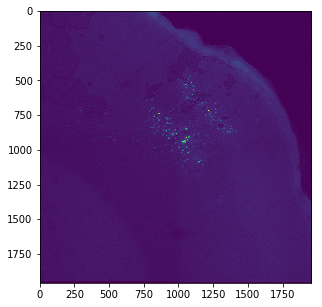

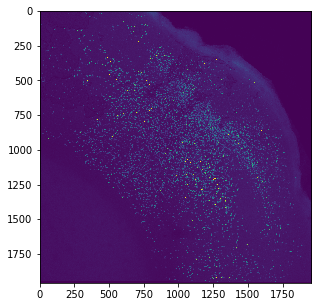

In [179]:
oldredmip = oldmips.stack_channel_images['ch02'][0]
oldgreenmip = oldmips.stack_channel_images['ch01'][0]
imglist = [oldredmip,oldgreenmip]
for img in imglist:
    f,ax = plt.subplots(figsize = (5,5))
    ax.imshow(img)


In [180]:
oldmips = None
oldredmip = None
oldgreenmip = None

In [181]:
from scipy.ndimage.filters import laplace, gaussian_laplace, gaussian_filter

newDatared = newData.stack_channel_images['ch02']
newDatagreen = newData.stack_channel_images['ch01']
newredMIP = newDatamips.stack_channel_images['ch02'][0]
print(newredMIP.shape)
newgreenMIP = newDatamips.stack_channel_images['ch01'][0]

gaussianredmip = gaussian_laplace(newredMIP,sigma = 3)
print(gaussianredmip.shape)

gausredbin = getBinary_runnable(gaussianredmip,use_percentile=True,percentile = .9)


(1959, 1959)
(1959, 1959)


uint8


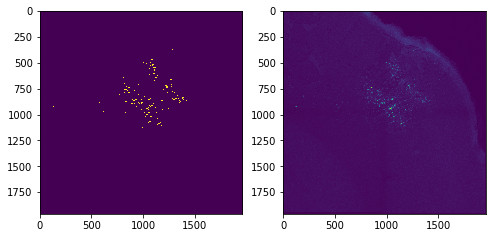

In [182]:
print(newredMIP.dtype)
f,ax = plt.subplots(ncols = 2,figsize = (8,8))
ax[0].imshow(gausredbin)
ax[1].imshow(newredMIP)


In [183]:
from skimage.morphology import watershed, disk, square, remove_small_objects
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte
import scipy.ndimage as ndi
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max

224


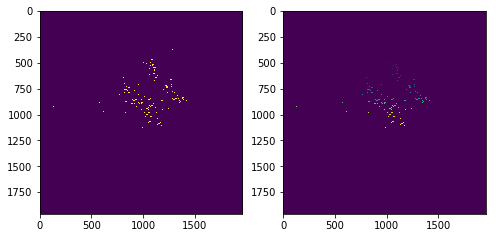

In [184]:
gausredbin_labeled = labelBinaryImage_runnable(gausredbin)
redgausprops = getImageCoordinates_runnable(gausredbin,intensity_image=newredMIP)
print(len(redgausprops))

f,ax = plt.subplots(ncols = 2,figsize = (8,5))
ax[0].imshow(gausredbin)
ax[1].imshow(gausredbin_labeled)

<IPython.core.display.Javascript object>


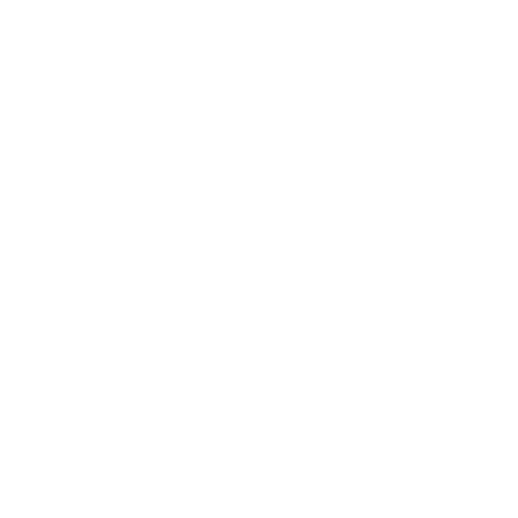

<IPython.core.display.Javascript object>


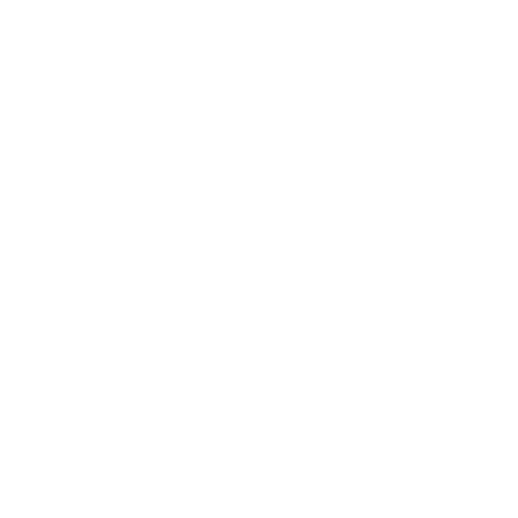

<IPython.core.display.Javascript object>


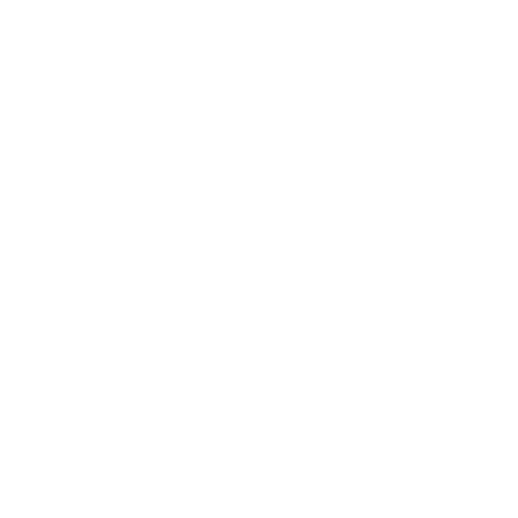

<IPython.core.display.Javascript object>


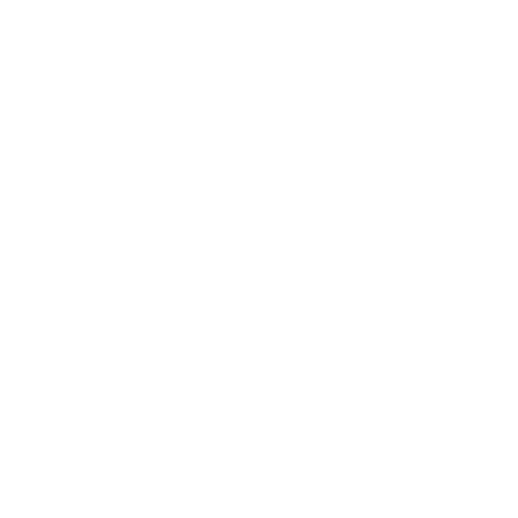

<IPython.core.display.Javascript object>


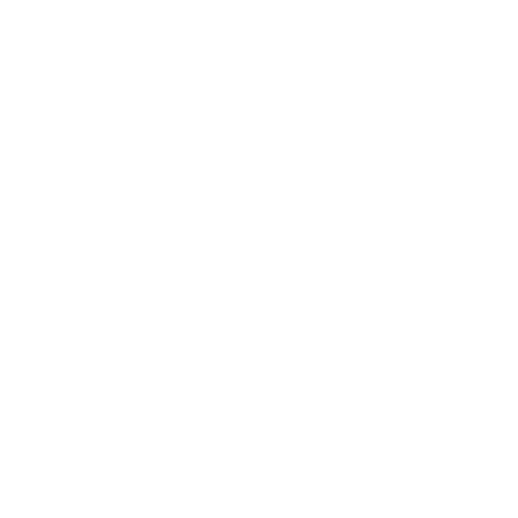

<IPython.core.display.Javascript object>


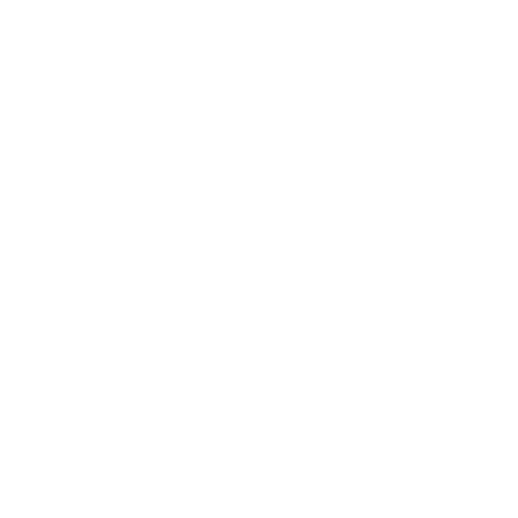

<IPython.core.display.Javascript object>


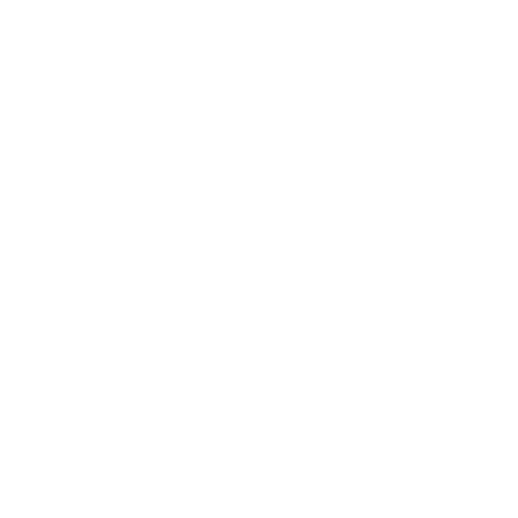

<IPython.core.display.Javascript object>


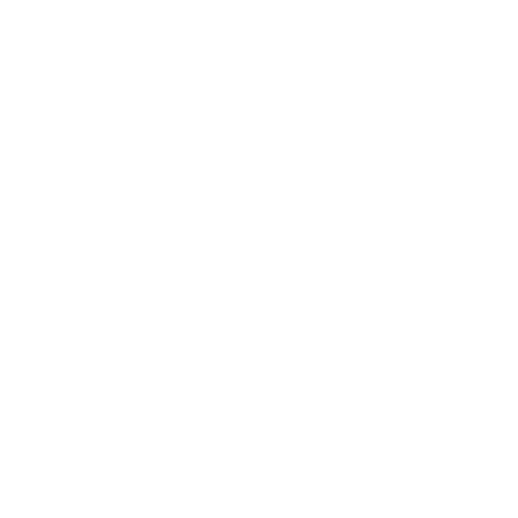

In [185]:
get_ipython().magic('matplotlib notebook')
openRedMIP = opening(newredMIP,selem = square(1))
plt.subplots(figsize = (8,8))
plt.imshow(openRedMIP)
gausOpen = gaussian_laplace(openRedMIP,sigma = 3)
binaryopenredmip = getBinary_runnable(gausOpen,use_percentile=True,percentile=.5)
plt.subplots(figsize = (8,8))
plt.imshow(gausOpen)

plt.subplots(figsize = (8,8))
plt.imshow(binaryopenredmip)
binaryopenredmip = labelBinaryImage_runnable(binaryopenredmip)
areaFilteredBin = remove_small_objects(binaryopenredmip,20)
binaryopenredmip = labelBinaryImage_runnable(areaFilteredBin)
redmipProps = getImageCoordinates_runnable(binaryopenredmip)

# print(len(redmipProps))

redmipProps = getImageCoordinates_runnable(areaFilteredBin)

plt.subplots(figsize =(8,8))
plt.imshow(labelBinaryImage_runnable(areaFilteredBin))

# print(len(redmipProps))
propsdict = {}
for i in range(len(redmipProps)):
    props = redmipProps[i]
    properties = {'bbox': props.bbox,
                         'area': props.filled_area,
                         'y' : int(props.centroid[1]),
                          'x' : int(props.centroid[0]),
                         'diameter': props.equivalent_diameter,
                         'label' : props.label}
#     print(i,props.label)
    propsdict[i] = properties
# print(propsdict)

In [ ]:
areas = []
for prop in redmipProps:
    areas.append(prop.filled_area)
print(len(areas))
print(np.median(areas),np.percentile(areas,25),np.percentile(areas,75),np.max(areas),np.min(areas))

In [186]:
dataset6_count = 0 

In [187]:
print(sorted(propsdict.keys()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173]


In [18]:
def removeObjects_runnable(labeled_image_cutout,image_properties):
    label = image_properties['label']
    clean_image = labeled_image_cutout*(labeled_image_cutout == label).astype(int)
    return clean_image

def getCutoutFieldStacks_runnable(cellDataObject,image_properties):
    assert(type(cellDataObject == CellData))
    
    x,y = image_properties['x'],image_properties['y']
    
    redstack = cellDataObject.stack_channel_images['ch02']
    greenstack = cellDataObject.stack_channel_images['ch01']

    assert(len(redstack)==len(greenstack))

    smallredstack = []
    smallgreenstack = []
    redhist = []
    greenbin = []
    redbin = []
    
    cutoutsize = int(4*image_properties['diameter'])
    
    for r,g in zip(redstack,greenstack):
        
        redcut = getImageCutouts(r,x,y,cutout=cutoutsize)
        redhist.append(np.std(redcut))
        redcut = opening(redcut,selem = square(1))
        smallbinred = getBinary_runnable(redcut,use_percentile = True,percentile = .5)
        
        greencut = getImageCutouts(g,x,y,cutout=cutoutsize)
        greencut = opening(greencut,selem = square(1))
        
        smallbingreen = getBinary_runnable(greencut,use_percentile=True,percentile = .3)
            
        
        smallredstack.append(redcut)
        redbin.append(smallbinred)
        
        smallgreenstack.append(greencut)
        greenbin.append(smallbingreen)
        
        
        
    smallredstack = np.asarray(smallredstack)
    smallgreenstack = np.asarray(smallgreenstack)
    redhist = np.asarray(redhist)
    greenbin = np.asarray(greenbin)
    redbin = np.asarray(redbin)
    
    dataDictionary = {'red_stack' : smallredstack,
                     'sigmas' : redhist,
                     'green_stack' : smallgreenstack,
                     'green_bin' : greenbin,
                     'red_bin' : redbin}
    return dataDictionary
        

        

In [102]:
dataset5_count = 0

In [155]:
plt.close('all')

In [188]:
%matplotlib inline
for i in range(len(propsdict)):
    if ((i % 10) == 0):
        print(dataset6_count)

    item = propsdict[i]
    x,y = item['x'],item['y']
#     print(item['label'])

    xstart,xstop = item['bbox'][0],item['bbox'][2]
    ystart,ystop = item['bbox'][1],item['bbox'][3]

    objectarea = int(item['area'])

    cutoutsize = int(4*item['diameter'])

    binary_cutout_image = cutImageByBoundary(binaryopenredmip,xstart=xstart,xstop=xstop,
                                             ystart=ystart,ystop=ystop)
    binredcut = getImageCutouts(binary_cutout_image,x,y,cutout=cutoutsize)

    binredcut = removeObjects_runnable(binredcut,item)

    smallred = getImageCutouts(newredMIP,x,y,cutout=cutoutsize)
    smallgreen = getImageCutouts(newgreenMIP,x,y,cutout=cutoutsize)
    
    

    fieldStacks = getCutoutFieldStacks_runnable(newData,item)
    
    smallredstack = fieldStacks['red_stack']
    smallgreenstack = fieldStacks['green_stack']
    redhist = fieldStacks['sigmas']
    greenbin = fieldStacks['green_bin']
    redbin = fieldStacks['red_bin']
    
    fieldStacks = None

    maxcount = 0
    finalfield = []
    for i in range(len(smallredstack)):


        if redhist[i] > np.percentile(redhist,70):


            smallbingreen = greenbin[i]
            smallbinred = redbin[i]


            labeledGreen1 = labelBinaryImage_runnable(smallbingreen)
            labeledGreen1 = remove_small_objects(labeledGreen1,5)
            themax = np.amax(labeledGreen1)
#             print('max in green is',themax,'for slice ',i)
            
            if themax == 1: 
                pass
            else:


                labeledRed = labelBinaryImage_runnable(smallbinred)

                fieldsize = labeledGreen1.shape[0]*labeledGreen1.shape[1]

                strucsize = int(0.25*fieldsize)

                trial = distance_transform_edt(smallbingreen)
                local_max =  peak_local_max(trial,indices = False,labels = labeledGreen1,min_distance=3)

                markers = ndi.label(local_max)[0]

                watershedGreen = watershed(-trial,markers,mask = labeledGreen1, watershed_line=True)




                labeledGreen = labelBinaryImage_runnable(watershedGreen)
                greenfieldProps = getImageCoordinates_runnable(labeledGreen)



                gareas = []
                subimg = np.zeros(labeledGreen.shape)
                for gprop in greenfieldProps:
                    props = {}
                    props['area'] = gprop.filled_area
                    props['label'] = gprop.label
                    gareas.append(props)

                for area in gareas:
                    if area['area'] < strucsize:

                        subimg = np.zeros(labeledGreen.shape)
                        pass
                    else:

                        subimg = area['label']*(labeledGreen == area['label'])
                        labeledGreen = labeledGreen - subimg


                redfieldProps = getImageCoordinates_runnable(labeledRed)        
                subimg = np.zeros(labeledRed.shape)
                rareas = []
                for rprop in redfieldProps:
                    props = {}
                    props['area'] = rprop.filled_area
                    props['label'] = rprop.label
                    rareas.append(props)

                for area in rareas:
                    if area['area'] < strucsize:

                        subimg = np.zeros(labeledGreen.shape)
                        pass
                    else:

                        subimg = area['label']*(labeledRed == area['label'])
                        labeledRed = labeledRed - subimg


                product = binredcut*labeledGreen
                final_product = labeledRed*product
                final_product = remove_small_objects(label(final_product),10)
                finalfield.append(final_product)
                labeledproductprops = getImageCoordinates_runnable(product)
                dosliceplots = False
                if (len(labeledproductprops) != 0) and (dosliceplots):
                    f,ax = plt.subplots(nrows = 4,ncols = 2, figsize = (14,10))
                    plt.subplots_adjust(top = 1.5)
                    ax[0][0].imshow(smallgreenstack[i])
                    ax[0][0].set_title('Green Channel slice %s'%(i))
                    ax[0][1].imshow(smallredstack[i])
                    ax[0][1].set_title('Red Channelslice %s'%(i))
                    ax[1][0].imshow(watershedGreen)
                    ax[1][0].set_title('Segmented Binary Green')
                    ax[1][1].imshow(labeledRed)
                    ax[1][1].set_title('Binary labeled Red')
                    ax[2][0].imshow(labeledGreen)
                    ax[2][0].set_title('Labeled Segmented Green')
                    ax[2][1].imshow(binredcut)
                    ax[2][1].set_title('Binary Red MIP')
                    ax[3][0].imshow(product)
                    ax[3][0].set_title('Field Product')
                    ax[3][1].imshow(final_product)
                    ax[3][1].set_title('Final Objects Detected')
                    
            

        

    
    if len(finalfield) == 0:
        finalMIP = np.zeros(smallred.shape)
    else:
        finalMIP = getMaxPro_runnable(finalfield)
        
    finalMIP = (finalMIP > 0).astype(np.uint8)
    finalMIP = labelBinaryImage_runnable(finalMIP)
    
    finalprops = getImageCoordinates_runnable(finalMIP)
    maxcount = len(finalprops)
    
    dataset6_count += maxcount
    
    doplots = False
    if doplots:
    
        f, ax = plt.subplots(ncols = 2,nrows=2,figsize = (10,8))
    #     plt.subplots_adjust(top = .2)
        ax[0][0].imshow(smallgreen)
        ax[0][0].set_title('green')
        ax[0][1].imshow(smallred)
        ax[0][1].set_title('red')
        ax[1][0].imshow(binredcut)
        ax[1][0].set_title('Initial Binary MIP')
        ax[1][1].imshow(finalMIP)
        ax[1][1].set_title('Dual Labeled Cells Detected')
        f.suptitle('Cell %s' %(item['label']),fontsize = 14)
    
    
smallred = None
smalgreen = None
finalMIP = None



smallredstack = None
smallgreenstack = None
redhist = None
greenbin = None
redbin = None



print('Final count',dataset3_count)
# plt.close()

0


C:\Users\roberts\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\morphology\misc.py:127: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


6
15
22
29
37
43
51
60
71
83
89
92
99
104
108
116
123
Final count 24


In [199]:
print(dataset3_count)

error = np.abs(dataset3_count - 19)
error /= 19
print(error)

24
0.2631578947368421


In [201]:
print(dataset4_count)
error = np.abs(dataset4_count-88)
error /= 88
print(error)

77
0.125


In [202]:
print(dataset5_count)
error = np.abs(dataset5_count - 151)
error /= 151
print(error)

125
0.17218543046357615


In [203]:
print(dataset6_count)
error = np.abs(dataset6_count - 134)
error /= 134
print(error)

125
0.06716417910447761


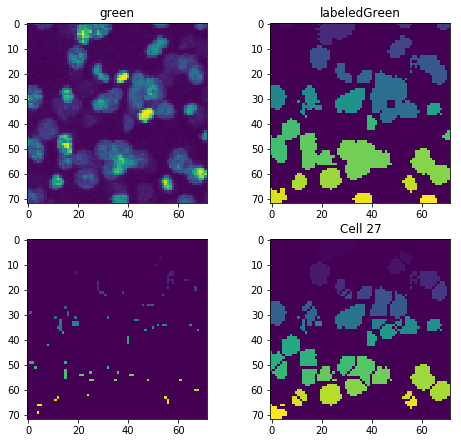

In [44]:
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
%matplotlib inline
item = propsdict[26]
x,y = item['x'],item['y']



xstart,xstop = item['bbox'][0],item['bbox'][2]
ystart,ystop = item['bbox'][1],item['bbox'][3]

objectarea = int(item['area'])

cutoutsize = int(4*item['diameter'])

smallred = getImageCutouts(newredMIP,x,y,cutout=cutoutsize)
smallgreen = getImageCutouts(newgreenMIP,x,y,cutout=cutoutsize)

smallgreenbinary = getBinary_runnable(smallgreen,use_percentile=True,percentile=0.5)
labeledGreen = labelBinaryImage_runnable(smallgreenbinary)


trial = distance_transform_edt(smallgreenbinary)
local_max =  peak_local_max(trial,indices = False,labels = labeledGreen)
markers = ndi.label(local_max)[0]



labels = watershed(-trial,markers,mask = labeledGreen, watershed_line=True)
f, ax = plt.subplots(nrows=2,ncols = 2,figsize = (8,4))
plt.subplots_adjust(top = 1.5)
ax[0][0].imshow(smallgreen)
ax[0][0].set_title('green')
ax[0][1].imshow(labeledGreen)
ax[0][1].set_title('labeledGreen')
ax[1][0].imshow(markers)
ax[1][1].imshow(labels)
plt.title('Cell %s' %(item['label']))


smallredbinary = getBinary_runnable(smallred,use_percentile=True,percentile=0.5)
labeledRed = labelBinaryImage_runnable(smallredbinary)

trialred = distance_transform_edt(smallredbinary)
local_max = peak_local_max(trialred,indices = False, labels = labeledRed)
markers = ndi.label(local_max)[0]

In [ ]:
dataset5_count

In [ ]:
get_ipython().magic('matplotlib notebook')
sevenprops = propsdict[6]
x,y = sevenprops['x'],sevenprops['y']
print(x,y)
img = getImageCutouts(binaryopenredmip,x,y,cutout=int(4*sevenprops['diameter']))
plt.subplots(figsize = (5,5))
plt.imshow(img)

erode = opening(img)
erode1 = erosion(erode)

plt.subplots(figsize = (5,5))
plt.imshow(np.hstack((erode,erode1)))

In [ ]:
img = getImageCutouts(areaFilteredBin,994,865)
plt.subplots(figsize= (8,8))
plt.imshow(img)

In [ ]:
dataset5_count

In [ ]:
dataset4_count

In [ ]:
dataset3_count

In [ ]:
print(dataset6_count,len(propsdict))

In [ ]:
dataset_count

In [ ]:
redset = newData.stack_channel_images['ch02']
redsetbin = np.zeros((redset.shape))
for i,z in enumerate(redset):
    redsetbin[i] = getBinary_runnable(z)
labelprops = getImageCoordinates_runnable(redsetbin)

In [ ]:
plt.subplots(figsize = (8,8))
plt.imshow(newredMIP)

In [ ]:
labeled3d = label(redsetbin)
plt.subplots(figsize = (8,8))
plt.imshow(labeled3d[1])

In [ ]:


    
areas = np.asarray(areas)
print(np.mean(areas),np.std(areas),np.percentile(areas,25))
areathreshold = 10
countedAreas = []
for i in range(len(redgausprops)):
    props = redgausprops[i]
    key = str(i)
    if (props.filled_area > areathreshold):
        properties = {'bbox': props.bbox,
                     'area': props.filled_area,
                     'centroid' : props.centroid,
                     'convex_image': props.convex_image,
                     'diameter': props.equivalent_diameter,
                     'image' : props.intensity_image,
                     'label' : props.label,
                     'eccentricity' : props.eccentricity}
        countedAreas.append(props.filled_area)
        
        propsdict[key] = properties
    
print(len(propsdict),len(countedAreas))

In [ ]:
areas = np.asarray(areas)
countedAreas = np.asarray(countedAreas)
print(np.amin(areas),np.amin(countedAreas))
areahist,edges = np.histogram(openRed)
countedhist,countedges = np.histogram(countedAreas)
print(edges)
print(countedges)

f,ax = plt.subplots(figsize = (10,5))
# ax[0]=plt.hist(areas,bins=50)
plt.hist(openRed,bins=len(edges))
plt.show()

In [ ]:
prop = propsdict[17]
x,y = int(prop['x']),int(prop['y'])
cutout = int(1.5*prop['diameter'])
smallred = getImageCutouts(newredMIP,x,y,cutout=cutout,fullImage=False)
smallgreen = getImageCutouts(newgreenMIP,x,y,cutout = cutout,fullImage=False)
openRed = opening(smallred,selem = square(2))

smallredbin = getImageCutouts(gausredbin_labeled,x,y,cutout=cutout,fullImage=False)

binOfOpen = getBinary_runnable(img=openRed)

openGreen = opening(smallgreen,selem = square(10))

labelOpen = labelBinaryImage_runnable(binOfOpen)

areaFiltered = remove_small_objects(labelOpen,10)



# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(openRed, disk(1))

greengrad = rank.gradient(smallgreen,disk(1))


f = plt.figure(figsize = (8,5))

ax1 = f.add_subplot(231)
ax1.imshow(smallred)

ax2 = f.add_subplot(232)
ax2.imshow(openRed)

ax3 = f.add_subplot(233)
ax3.imshow(binOfOpen)

ax4 = f.add_subplot(234)
ax4.imshow(smallredbin)

ax5 = f.add_subplot(235)
ax5.imshow(labelOpen)


ax6 = f.add_subplot(236)
ax6.imshow(areaFiltered)






In [ ]:
Properties = getImageCoordinates_runnable(areaFiltered)


for pro in Properties:
    print(pro.centroid, pro.filled_area, pro.equivalent_diameter)

In [ ]:

for key in sorted(propsdict.keys()):
    prop = propsdict[key]
    x,y = int(prop['centroid'][0]),int(prop['centroid'][1])
    cutoutsize = int(1.5*prop['diameter'])
    redimg = getImageCutouts(newredMIP,x,y,cutout=cutoutsize,fullImage=False)
    redbin = getImageCutouts(gausredbin_labeled,x,y,cutout=cutoutsize,fullImage=False)
    greenimg = getImageCutouts(newgreenMIP,x,y,cutout=cutoutsize,fullImage=False)
    greensigma = measureNoise_runnable(greenimg)
    f,ax = plt.subplots(nrows=2,ncols = 2, figsize = (8,10))
    greenredbin = greenimg*(greenimg*redbin)
    ax[0][0].imshow(redimg)
    ax[0][0].set_title('Red')
    ax[0][1].imshow(greenimg)
    ax[0][1].set_title('Green')
    ax[1][0].imshow(redbin)
    ax[1][0].set_title('Red Binarized')
    ax[1][1].imshow(greenredbin)
    ax[1][1].set_title('Green Image * Red Binary')
    centroid = str(prop['centroid'])
    Label = str(prop['label'])
    f.suptitle('region %s at %s,%s'%(Label,x,y))

In [ ]:
keylist = ['107']
for key in keylist:
    prop = propsdict[key]
    x,y = int(prop['centroid'][0]),int(prop['centroid'][1])
    cutoutsize = int(1.5*prop['diameter'])
    redimg = getImageCutouts(newredMIP,x,y,cutout=cutoutsize,fullImage=False)
    redbin = getImageCutouts(gausredbin_labeled,x,y,cutout=cutoutsize,fullImage=False)
    greenimg = getImageCutouts(newgreenMIP,x,y,cutout=cutoutsize,fullImage=False)
    f,ax = plt.subplots(nrows=2,ncols = 2, figsize = (10,8))
    greenredbin = (greenimg*redbin)
    ax[0][0].imshow(redimg)
    ax[0][0].set_title('Red')
    ax[0][1].imshow(greenimg)
    ax[0][1].set_title('Green')
    ax[1][0].imshow(redbin)
    ax[1][0].set_title('Red Binarized')
    ax[1][1].imshow(greenredbin)
    ax[1][1].set_title('Green Image * Red Binary')
    centroid = str(prop['centroid'])
    Label = str(prop['label'])
    f.suptitle('region %s at %s,%s'%(Label,x,y))



In [ ]:

key = '118'
prop = propsdict[key]
x,y = int(prop['centroid'][0]),int(prop['centroid'][1])
cutoutsize = int(prop['diameter'])

redimg = getImageCutouts(newredMIP,x,y,cutout=cutoutsize,fullImage=False)
redbin = getImageCutouts(gausredbin_labeled,x,y,cutout=cutoutsize,fullImage=False)
greenStack = newData.stack_channel_images['ch01']
redStack = newData.stack_channel_images['ch02']
green3dcutout = np.zeros((len(greenStack),greenimg.shape[0],greenimg.shape[1]))
red3dcutout = np.zeros((len(redStack),redimg.shape[0],redimg.shape[1]))
for i,z in enumerate(greenStack):
    greencut = getImageCutouts(z,x,y,cutout = cutoutsize,fullImage = False)
    redcut = getImageCutouts(redStack[i],x,y,cutout = cutoutsize,fullImage=False)
    redstd = np.square(np.std(redcut))
    greenstd = np.square(np.std(greencut))
    

    if (redstd < 15) and (greenstd < 5):
        pass
#         greentransform = np.fft.fft2(greencut)
#         redtransform = np.fft.fft2(redcut)
#         product = greentransform*redtransform
#         ccimg = np.fft.ifft2(product)
#         ccimg = ccimg.real
    else:
        ccimg = correlate2d(redcut,greencut)
        gcutbin = getBinary_runnable(greencut)
        rcutbin = getBinary_runnable(redcut)
        f = plt.figure(figsize = (12,5))
        ax1 = f.add_subplot(231)
        ax1.imshow(greencut)
        ax2 = f.add_subplot(232)
        ax2.imshow(redcut)
        ax3 = f.add_subplot(233)
        img3 = ax3.imshow(ccimg)
        cbar = f.colorbar(img3,ax=ax3,orientation = 'vertical',fraction = 0.05)
        ax4 = f.add_subplot(234)
        ax4.imshow(gcutbin)
        ax5 = f.add_subplot(235)
        ax5.imshow(rcutbin)
        ax6 = f.add_subplot(236)
        ax6.imshow(rcutbin*gcutbin)
        


In [ ]:
key = '21'
prop = propsdict[key]
x,y = int(prop['centroid'][0]),int(prop['centroid'][1])
cutoutsize = int(prop['diameter'])

redimg = getImageCutouts(newredMIP,x,y,cutout=cutoutsize,fullImage=False)
redbin = getImageCutouts(gausredbin_labeled,x,y,cutout=cutoutsize,fullImage=False)
greenStack = newData.stack_channel_images['ch01']
redStack = newData.stack_channel_images['ch02']
green3dcutout = np.zeros((len(greenStack),redimg.shape[0],redimg.shape[1]))
red3dcutout = np.zeros((len(redStack),redimg.shape[0],redimg.shape[1]))
for i,z in enumerate(greenStack):
    greencut = getImageCutouts(z,x,y,cutout = cutoutsize,fullImage = False)
    redcut = getImageCutouts(redStack[i],x,y,cutout = cutoutsize,fullImage=False)
    redvar = np.var(redcut)
    greenvar = np.var(greencut)
    
    

#     if (redvar < 15) and (greenvar < 5):
#         pass
# #         greentransform = np.fft.fft2(greencut)
# #         redtransform = np.fft.fft2(redcut)
# #         product = greentransform*redtransform
# #         ccimg = np.fft.ifft2(product)
# #         ccimg = ccimg.real
#     else:
    ccimg = correlate2d(redcut,greencut)
    gcutbin = getBinary_runnable(greencut)
    rcutbin = getBinary_runnable(redcut)
    print('red noise:', estimate_sigma(redcut))
    print('green noise:',estimate_sigma(greencut))
    f = plt.figure(figsize = (12,5))
    ax1 = f.add_subplot(231)
    ax1.imshow(greencut)
    ax2 = f.add_subplot(232)
    ax2.imshow(redcut)
    ax3 = f.add_subplot(233)
    img3 = ax3.imshow(ccimg)
    cbar = f.colorbar(img3,ax=ax3,orientation = 'vertical',fraction = 0.05)
    ax4 = f.add_subplot(234)
    ax4.imshow(gcutbin)
    ax5 = f.add_subplot(235)
    ax5.imshow(rcutbin)
    ax6 = f.add_subplot(236)
    ax6.imshow(rcutbin*gcutbin)

In [ ]:
testData = None

In [ ]:
testData = None
Folder = os.path.join(practice_data_folder,'03','06_L','Background_SubTracted_Images')
testData = CellData(directory = Folder)
testData.loadImages()

In [ ]:
testData.processImages(runnabledict = binary_dict, process_stack=True,process_mips=False)

In [ ]:
testData.processImages(runnabledict=backsub_dict,process_stack=True,process_mips=False)

In [ ]:
binary_array = testData.processed_stack_images['ch01']['getBinary_runnable']
testData.stack_channel_images['ch01'][0].dtype

In [ ]:
def saveImages(imgStack,savedir,foldername,filenames):
    final_savedir = os.path.join(savedir,foldername)
    if not os.path.exists(final_savedir):
        os.mkdir(final_savedir)
    for i in range(len(imgStack)):
        tf.imsave(os.path.join(final_savedir,filenames[i]),imgStack[i])
    return

In [ ]:
greenBG = testData.stack_channel_images['ch01']
redBG = testData.stack_channel_images['ch02']

In [ ]:
GFPmaxpro = getMaxPro_runnable(greenBG)
binaryGFP = getBinary_runnable(GFPmaxpro)
binaryGFP_90percentotsu = getBinary_runnable(GFPmaxpro,use_percentile=True,percentile=0.9)
binaryGFP_85percentotsu = getBinary_runnable(GFPmaxpro,use_percentile=True,percentile=0.85)
binaryGFP_75percentotsu = getBinary_runnable(GFPmaxpro,use_percentile=True,percentile=0.75)

RFPmaxpro = getMaxPro_runnable(redBG)
binaryRFP = getBinary_runnable(RFPmaxpro)

In [ ]:
GFPcoords = getImageCoordinates_runnable(binaryGFP.astype(int))
GFP_90percentilecoords = getImageCoordinates_runnable(binaryGFP_90percentotsu.astype(int))
GFP_85percentilecoords = getImageCoordinates_runnable(binaryGFP_85percentotsu.astype(int))
GFP_75percentilecoords = getImageCoordinates_runnable(binaryGFP_75percentotsu.astype(int))
print(len(GFPcoords),len(GFP_90percentilecoords),len(GFP_85percentilecoords), len(GFP_75percentilecoords))
x,y = GFPcoords[23].centroid
x,y = x.astype(int),y.astype(int)
print(x,y)


In [ ]:
largefield = np.zeros(GFPmaxpro.shape)
for i in range(22,26,1):
    x,y = GFPcoords[i].centroid
    x,y = x.astype(int),y.astype(int)
    largefield+= getImageCutouts(GFPmaxpro,x,y)
    smallfield = getImageCutouts(GFPmaxpro,x,y,fullImage = False)
    smallbinary = getImageCutouts(binaryGFP,x,y,fullImage = False)
    convexhull = getConvexHull(smallbinary)
    f,(ax1,ax2,ax3) = plt.subplots(ncols =3,figsize = (12,12))
    ax1.imshow(smallfield)
    ax2.imshow(smallbinary)
    ax3.imshow(convexhull)
    

# img =getImageCutouts(GFPmaxpro,x,y)




In [ ]:
largefield_90otsu = np.zeros(GFPmaxpro.shape)
for i in range(1,10):
    x,y = GFP_90percentilecoords[i].centroid
    x,y = x.astype(int),y.astype(int)
    largefield_90otsu += getImageCutouts(GFPmaxpro,x,y)
    smallfieldGFP = getImageCutouts(GFPmaxpro,x,y,fullImage = False)
    smallbinary = getImageCutouts(binaryGFP_90percentotsu,x,y,fullImage=False)
    smallfieldRFP = getImageCutouts(RFPmaxpro,x,y,fullImage=False)
    f,(ax1,ax2,ax3) = plt.subplots(ncols = 3,figsize = (12,12))
    ax1.imshow(smallfieldGFP)
    ax2.imshow(smallbinary)
    ax3.imshow(smallfieldRFP)
plt.subplots(figsize = (15,15))
plt.imshow(largefield_90otsu)

In [ ]:
largefield_85otsu = np.zeros(GFPmaxpro.shape)
largefield_RFP85otsu = np.zeros(RFPmaxpro.shape)
for i in range(len(GFP_85percentilecoords)):
    x,y = GFP_85percentilecoords[i].centroid
    x,y = x.astype(int),y.astype(int)
    largefield_85otsu += getImageCutouts(GFPmaxpro,x,y)
    largefield_RFP85otsu += getImageCutouts(RFPmaxpro,x,y)
#     smallfieldGFP = getImageCutouts(GFPmaxpro,x,y,fullImage = False)
#     smallbinary = getImageCutouts(binaryGFP_85percentotsu,x,y,fullImage=False)
#     smallfieldRFP = getImageCutouts(RFPmaxpro,x,y,fullImage=False)
#     f,(ax1,ax2,ax3) = plt.subplots(ncols = 3,figsize = (12,12))
#     ax1.imshow(smallfieldGFP)
#     ax2.imshow(smallbinary)
#     ax3.imshow(smallfieldRFP)
plt.subplots(figsize = (15,15))
plt.imshow(largefield_85otsu)

plt.subplots(figsize = (15,15))
plt.imshow(largefield_RFP85otsu)

In [ ]:
largefield_75otsu = np.zeros(GFPmaxpro.shape)
largefield_RFP75otsu = np.zeros(RFPmaxpro.shape)
for i in range(len(GFP_75percentilecoords)):
    x,y = GFP_75percentilecoords[i].centroid
    x,y = x.astype(int),y.astype(int)
    largefield_75otsu += getImageCutouts(GFPmaxpro,x,y)
    largefield_RFP75otsu += getImageCutouts(RFPmaxpro,x,y)
#     smallfieldGFP = getImageCutouts(GFPmaxpro,x,y,fullImage = False)
#     smallbinary = getImageCutouts(binaryGFP_85percentotsu,x,y,fullImage=False)
#     smallfieldRFP = getImageCutouts(RFPmaxpro,x,y,fullImage=False)
#     f,(ax1,ax2,ax3) = plt.subplots(ncols = 3,figsize = (12,12))
#     ax1.imshow(smallfieldGFP)
#     ax2.imshow(smallbinary)
#     ax3.imshow(smallfieldRFP)
plt.subplots(figsize = (15,15))
plt.imshow(largefield_75otsu)

plt.subplots(figsize = (15,15))
plt.imshow(largefield_RFP75otsu)

In [ ]:
for i in range(10):
    x,y = GFP_75percentilecoords[i].centroid
    x,y = x.astype(int),y.astype(int)
    smallfieldGFP = getImageCutouts(GFPmaxpro,x,y,fullImage = False)
    smallbinary = getImageCutouts(binaryGFP_75percentotsu,x,y,fullImage=False)
    smallfieldRFP = getImageCutouts(RFPmaxpro,x,y,fullImage=False)
    f,(ax1,ax2,ax3) = plt.subplots(ncols = 3,figsize = (12,12))
    ax1.imshow(smallfieldGFP)
    ax2.imshow(smallbinary)
    ax3.imshow(smallfieldRFP)

In [ ]:
avggreenlist = np.asarray(avggreenlist)
plt.subplots(figsize = (8,8))
plt.hist(avggreenlist,bins = 10)
plt.show()


In [ ]:
labeledimg,num = label(binaryGFP,return_num=True,neighbors=8)
props = regionprops(labeledimg)
plt.subplots(figsize = (10,10))
plt.imshow(labeledimg)

In [ ]:

f,(ax1,ax2) = plt.subplots(ncols = 2,figsize = (15,10))
ax1.imshow(binaryGFP_90percentotsu)
ax2.imshow(binaryGFP)

In [ ]:


f,(ax1,ax2) = plt.subplots(ncols = 2,figsize = (16,16))
ax1.imshow(trial)
ax2.imshow(binary)

In [ ]:
redtrial = getMaxPro_runnable(redBG)
binaryred = getBinary_runnable(redtrial)

animg = np.multiply(redtrial,binaryGFP)

f,ax1 = plt.subplots(figsize = (10,10))
ax1.imshow(binaryred)

f,ax1 = plt.subplots(figsize = (10,10))
ax1.imshow(redtrial)

In [ ]:
plt.subplots(figsize = (10,10))
plt.imshow(np.sum(mip,axis=0))

plt.colorbar()

In [ ]:
testData.processImages(binary_dict,
                      process_mips = False,process_stack = True)

In [ ]:


stack03_metadata['image files'] = {}
stack03_metadata['datapath'] = os.path.join(practice_data_folder,'03','06_L','Stack')
mippath = os.path.join(practice_data_folder,'03','06_L','MIP')

stack3files = sorted([os.path.join(stack3path,x) for x in os.listdir(stack3path) if 'tif' in x])
mipfiles = sorted([os.path.join(mippath,x) for x in os.listdir(mippath) if 'tif' in x])

stack03_metadata['image files']['dapi'] = sorted([x for x in stack3files if 'ch00' in x])
stack03_metadata['image files']['gfp'] = sorted([x for x in stack3files if 'ch01' in x])
stack03_metadata['image files']['rfp'] = sorted([x for x in stack3files if 'ch02' in x])

stack03_metadata['image files']['dapi mip'] = sorted([x for x in mipfiles if 'ch00' in x])
stack03_metadata['image files']['gfp mip'] = sorted([x for x in mipfiles if 'ch01' in x])
stack03_metadata['image files']['rfp mip'] = sorted([x for x in mipfiles if 'ch02' in x])



In [ ]:
stack03_metadata_json_filename = 'stack_03_metadata.json'
filepath = os.path.join(practice_data_folder,stack03_metadata_json_filename)
with open(filepath,'w') as f:
    json.dump(stack03_metadata,f)

In [ ]:
gfpstack = readImgStack(stack03_metadata['image files']['gfp'])
gaussianLaplacegfp = ft.gaussianLaplaceFilter(gfpstack,sigma=0.5)

In [ ]:
newgfpStack = np.zeros((len(gfpstack),2048,2048))
for i in range(len(gfpstack)):
    newgfpStack[i] = np.pad(gfpstack[i],((48,49),(45,46)),'constant',constant_values = 0)
gfpstack = newgfpStack
newgfpStack = None

In [ ]:
gfp0sub = backgroundSubtraction(gfpstack[0],50,True)

In [ ]:
plt.subplots(figsize = (16,16))
plt.imshow(gfpstack[0])

In [ ]:
gfpMIP = tf.imread(stack03_metadata['image files']['gfp mip'])
gfpMIP = np.pad(gfpMIP,((49,49),(46,46)),'constant',constant_values = 0)

In [ ]:
plt.subplots(figsize = (16,16))
plt.imshow(gfp0sub)

In [ ]:
plt.subplots(figsize = (16,16))
plt.imshow(gfpMIP)

In [ ]:
plt.subplots(figsize = (16,16))
plt.imshow(filters.gaussian_laplace(gfpMIP,sigma=0.5))

In [ ]:
plt.subplots(figsize = (16,16))
plt.imshow(gfpMIP)

In [ ]:
subgfpMIP = backgroundSubtraction(gfpMIP,32,True)

In [ ]:
plt.subplots(figsize = (16,16))
plt.imshow(subgfpMIP)

In [ ]:
threshold = filters.threshold_otsu(subgfpMIP)
GFPbinimg = (subgfpMIP > threshold)
threshGFPsub = GFPbinimg*subgfpMIP

In [ ]:
plt.subplots(figsize = (16,16))
plt.imshow(threshGFPsub)

In [ ]:
plt.subplots(figsize = (16,16))
plt.imshow(GFPbinimg)

In [ ]:
gfpstack = None

In [30]:
whos

Variable                         Type                 Data/Info
---------------------------------------------------------------
CellData                         type                 <class '__main__.CellData'>
HTML                             type                 <class 'IPython.core.display.HTML'>
ProcessingPool                   type                 <class 'pathos.multiprocessing.ProcessPool'>
area                             dict                 n=2
areaFilteredBin                  ndarray              1959x1959: 3837681 elems, type `int64`, 30701448 bytes (29.27918243408203 Mb)
ax                               ndarray              4x2: 8 elems, type `object`, 64 bytes
backgroundSubtraction_runnable   function             <function backgroundSubtr<...>le at 0x000001E9693E16A8>
backsub_dict                     dict                 n=2
binary_cutout_image              ndarray              1959x1959: 3837681 elems, type `int32`, 15350724 bytes (14.639591217041016 Mb)
binary_dict       

In [ ]:
img = skimage.io.imread(newData.stack_channel_files['ch01'][0])

plt.subplots(figsize = (10,10))
plt.imshow(img)

In [ ]:
adict = {}
print(len(adict))